Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Task 1: Tải và Tiền xử lý Dữ liệu

### 1.1. Viết hàm đọc file CoNLL-U

In [2]:
def load_conllu(file_path):
    """
    Đọc file CoNLL-U và trả về danh sách các câu.
    Mỗi câu là list các tuple (word, upos_tag).

    Args:
        file_path: Đường dẫn đến file .conllu

    Returns:
        List[List[Tuple[str, str]]]: Danh sách các câu
    """
    sentences = []
    current_sentence = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()

            # Skip comments and empty lines
            if line.startswith('#'):
                continue

            if not line:
                # End of sentence
                if current_sentence:
                    sentences.append(current_sentence)
                    current_sentence = []
                continue

            # Parse line
            fields = line.split('\t')

            # Skip multi-word tokens (lines with '-' in ID)
            if '-' in fields[0] or '.' in fields[0]:
                continue

            # Extract FORM (column 1) and UPOS (column 3)
            word = fields[1]
            upos = fields[3]

            current_sentence.append((word, upos))

    # Add last sentence if exists
    if current_sentence:
        sentences.append(current_sentence)

    return sentences

# Load data
train_path = '/content/UD_English-EWT/en_ewt-ud-train.conllu'
dev_path = '/content/UD_English-EWT/en_ewt-ud-dev.conllu'
test_path = '/content/UD_English-EWT/en_ewt-ud-test.conllu'

train_sentences = load_conllu(train_path)
dev_sentences = load_conllu(dev_path)
test_sentences = load_conllu(test_path)

print(f"Number of training sentences: {len(train_sentences)}")
print(f"Number of dev sentences: {len(dev_sentences)}")
print(f"Number of test sentences: {len(test_sentences)}")
print(f"\nExample sentence (first 5 tokens):")
print(train_sentences[0][:5])

Number of training sentences: 12544
Number of dev sentences: 2001
Number of test sentences: 2077

Example sentence (first 5 tokens):
[('Al', 'PROPN'), ('-', 'PUNCT'), ('Zaman', 'PROPN'), (':', 'PUNCT'), ('American', 'ADJ')]


### 1.2. Xây dựng Từ điển (Vocabulary)

In [3]:
def build_vocab(sentences, min_freq=2):
    """
    Xây dựng từ điển từ danh sách các câu.

    Args:
        sentences: List[List[Tuple[str, str]]] - Danh sách các câu
        min_freq: int - Tần suất tối thiểu để từ được đưa vào từ điển

    Returns:
        word_to_ix: Dict[str, int] - Từ điển từ -> index
        tag_to_ix: Dict[str, int] - Từ điển tag -> index
    """
    # Count word and tag frequencies
    word_counter = Counter()
    tag_counter = Counter()

    for sentence in sentences:
        for word, tag in sentence:
            word_counter[word] += 1
            tag_counter[tag] += 1

    # Build word vocabulary with special tokens
    word_to_ix = {'<PAD>': 0, '<UNK>': 1}
    for word, count in word_counter.items():
        if count >= min_freq:
            word_to_ix[word] = len(word_to_ix)

    # Build tag vocabulary with PAD token
    tag_to_ix = {'<PAD>': 0}
    for tag in tag_counter.keys():
        tag_to_ix[tag] = len(tag_to_ix)

    return word_to_ix, tag_to_ix

# Build vocabularies from training data
word_to_ix, tag_to_ix = build_vocab(train_sentences, min_freq=2)

# Create reverse mapping for tags
ix_to_tag = {v: k for k, v in tag_to_ix.items()}

print(f"Vocabulary size (words): {len(word_to_ix)}")
print(f"Vocabulary size (tags): {len(tag_to_ix)}")
print(f"\nTag vocabulary: {list(tag_to_ix.keys())}")
print(f"\nFirst 20 words in vocabulary: {list(word_to_ix.keys())[:20]}")

Vocabulary size (words): 9875
Vocabulary size (tags): 18

Tag vocabulary: ['<PAD>', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'DET', 'ADP', 'AUX', 'PRON', 'PART', 'SCONJ', 'NUM', 'ADV', 'CCONJ', 'X', 'INTJ', 'SYM']

First 20 words in vocabulary: ['<PAD>', '<UNK>', 'Al', '-', 'Zaman', ':', 'American', 'forces', 'killed', 'Shaikh', 'al', ',', 'the', 'preacher', 'at', 'mosque', 'in', 'town', 'of', 'Qaim']


## Task 2: Tạo PyTorch Dataset và DataLoader

### 2.1. Tạo lớp POSDataset

In [4]:
class POSDataset(Dataset):
    """
    PyTorch Dataset cho bài toán POS Tagging.
    """
    def __init__(self, sentences, word_to_ix, tag_to_ix):
        """
        Args:
            sentences: List[List[Tuple[str, str]]] - Danh sách các câu
            word_to_ix: Dict[str, int] - Từ điển từ -> index
            tag_to_ix: Dict[str, int] - Từ điển tag -> index
        """
        self.sentences = sentences
        self.word_to_ix = word_to_ix
        self.tag_to_ix = tag_to_ix
        self.unk_idx = word_to_ix['<UNK>']

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        """
        Trả về một câu dưới dạng tensor indices.

        Returns:
            sentence_indices: torch.LongTensor - Indices của các từ trong câu
            tag_indices: torch.LongTensor - Indices của các tag trong câu
        """
        sentence = self.sentences[idx]

        # Convert words and tags to indices
        sentence_indices = []
        tag_indices = []

        for word, tag in sentence:
            # Use <UNK> for out-of-vocabulary words
            word_idx = self.word_to_ix.get(word, self.unk_idx)
            tag_idx = self.tag_to_ix[tag]

            sentence_indices.append(word_idx)
            tag_indices.append(tag_idx)

        return torch.LongTensor(sentence_indices), torch.LongTensor(tag_indices)

# Test dataset
train_dataset = POSDataset(train_sentences, word_to_ix, tag_to_ix)
print(f"Dataset size: {len(train_dataset)}")
print(f"\nExample item:")
words, tags = train_dataset[0]
print(f"Word indices shape: {words.shape}")
print(f"Tag indices shape: {tags.shape}")
print(f"\nFirst sentence (indices): {words[:10]}")
print(f"First tags (indices): {tags[:10]}")

Dataset size: 12544

Example item:
Word indices shape: torch.Size([29])
Tag indices shape: torch.Size([29])

First sentence (indices): tensor([ 2,  3,  4,  5,  6,  7,  8,  9,  1, 10])
First tags (indices): tensor([1, 2, 1, 2, 3, 4, 5, 1, 1, 1])


### 2.2. Tạo Collate Function và DataLoader

In [5]:
def collate_fn(batch):
    """
    Collate function để padding các câu trong batch về cùng độ dài.

    Args:
        batch: List[Tuple[Tensor, Tensor]] - Batch các câu

    Returns:
        padded_sentences: Tensor[batch_size, max_len] - Các câu đã được padding
        padded_tags: Tensor[batch_size, max_len] - Các tag đã được padding
        lengths: Tensor[batch_size] - Độ dài thực của mỗi câu
    """
    # Separate sentences and tags
    sentences, tags = zip(*batch)

    # Get original lengths
    lengths = torch.LongTensor([len(s) for s in sentences])

    # Pad sequences (padding_value=0 for both words and tags)
    padded_sentences = pad_sequence(sentences, batch_first=True, padding_value=0)
    padded_tags = pad_sequence(tags, batch_first=True, padding_value=0)

    return padded_sentences, padded_tags, lengths

# Create datasets
train_dataset = POSDataset(train_sentences, word_to_ix, tag_to_ix)
dev_dataset = POSDataset(dev_sentences, word_to_ix, tag_to_ix)
test_dataset = POSDataset(test_sentences, word_to_ix, tag_to_ix)

# Create dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

dev_loader = DataLoader(
    dev_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in dev_loader: {len(dev_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

# Test batch
batch_sentences, batch_tags, batch_lengths = next(iter(train_loader))
print(f"\nBatch shapes:")
print(f"Sentences: {batch_sentences.shape}")
print(f"Tags: {batch_tags.shape}")
print(f"Lengths: {batch_lengths.shape}")
print(f"\nLengths: {batch_lengths}")

Number of batches in train_loader: 392
Number of batches in dev_loader: 63
Number of batches in test_loader: 65

Batch shapes:
Sentences: torch.Size([32, 57])
Tags: torch.Size([32, 57])
Lengths: torch.Size([32])

Lengths: tensor([ 1,  2,  8, 29, 26, 26,  4,  8,  9, 11, 22, 25,  8, 11, 26, 32, 14,  7,
         2, 34, 19, 17,  8, 14,  9, 23, 24, 11, 57, 17, 12, 32])


## Task 3: Xây dựng Mô hình RNN

In [6]:
class SimpleRNNForTokenClassification(nn.Module):
    """
    Mô hình RNN đơn giản cho bài toán POS Tagging.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, tagset_size, num_layers=1):
        """
        Args:
            vocab_size: int - Kích thước từ vựng
            embedding_dim: int - Chiều của word embedding
            hidden_dim: int - Chiều của hidden state trong RNN
            tagset_size: int - Số lượng tag (POS tags)
            num_layers: int - Số lượng layers trong RNN
        """
        super(SimpleRNNForTokenClassification, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Embedding layer: vocab_size -> embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # RNN layer: embedding_dim -> hidden_dim
        self.rnn = nn.RNN(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False
        )

        # Output layer: hidden_dim -> tagset_size
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentences):
        """
        Forward pass.

        Args:
            sentences: Tensor[batch_size, seq_len] - Input sentences (word indices)

        Returns:
            tag_scores: Tensor[batch_size, seq_len, tagset_size] - Tag scores for each token
        """
        # sentences: [batch_size, seq_len]

        # Embedding: [batch_size, seq_len, embedding_dim]
        embeds = self.embedding(sentences)

        # RNN output: [batch_size, seq_len, hidden_dim]
        # rnn_out contains hidden states for all time steps
        rnn_out, hidden = self.rnn(embeds)

        # Linear layer: [batch_size, seq_len, tagset_size]
        tag_scores = self.fc(rnn_out)

        return tag_scores

# Model hyperparameters
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
NUM_LAYERS = 1

# Initialize model
model = SimpleRNNForTokenClassification(
    vocab_size=len(word_to_ix),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    tagset_size=len(tag_to_ix),
    num_layers=NUM_LAYERS
).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

SimpleRNNForTokenClassification(
  (embedding): Embedding(9875, 100, padding_idx=0)
  (rnn): RNN(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=18, bias=True)
)

Total parameters: 1019262
Trainable parameters: 1019262


## Task 4: Huấn luyện Mô hình

### 4.1. Khởi tạo Optimizer và Loss Function

In [7]:
# Loss function - ignore padding tokens (index 0)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Optimizer
LEARNING_RATE = 0.001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")

Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


### 4.2. Training Loop

In [8]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train model for one epoch.

    Returns:
        avg_loss: float - Average loss for the epoch
    """
    model.train()
    total_loss = 0

    for sentences, tags, lengths in tqdm(dataloader, desc="Training"):
        # Move to device
        sentences = sentences.to(device)
        tags = tags.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        tag_scores = model(sentences)  # [batch_size, seq_len, tagset_size]

        # Reshape for loss calculation
        # tag_scores: [batch_size * seq_len, tagset_size]
        # tags: [batch_size * seq_len]
        tag_scores = tag_scores.view(-1, tag_scores.shape[-1])
        tags = tags.view(-1)

        # Calculate loss
        loss = criterion(tag_scores, tags)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

print("Training function defined successfully!")

Training function defined successfully!


## Task 5: Đánh giá Mô hình

### 5.1. Evaluation Function

In [9]:
def evaluate(model, dataloader, criterion, device):
    """
    Evaluate model on validation/test set.

    Returns:
        avg_loss: float - Average loss
        accuracy: float - Token-level accuracy (excluding padding)
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for sentences, tags, lengths in tqdm(dataloader, desc="Evaluating"):
            # Move to device
            sentences = sentences.to(device)
            tags = tags.to(device)

            # Forward pass
            tag_scores = model(sentences)  # [batch_size, seq_len, tagset_size]

            # Calculate loss
            tag_scores_flat = tag_scores.view(-1, tag_scores.shape[-1])
            tags_flat = tags.view(-1)
            loss = criterion(tag_scores_flat, tags_flat)
            total_loss += loss.item()

            # Get predictions
            predictions = torch.argmax(tag_scores, dim=-1)  # [batch_size, seq_len]

            # Calculate accuracy (excluding padding tokens)
            mask = (tags != 0)  # Mask for non-padding tokens
            correct += ((predictions == tags) & mask).sum().item()
            total += mask.sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total if total > 0 else 0

    return avg_loss, accuracy

print("Evaluation function defined successfully!")

Evaluation function defined successfully!


### 5.2. Full Training Loop

In [10]:
# Training parameters
NUM_EPOCHS = 10

# For tracking
train_losses = []
dev_losses = []
dev_accuracies = []
best_dev_acc = 0
best_model_state = None

print("Starting training...\n")

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*60}")

    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Evaluate on dev set
    dev_loss, dev_acc = evaluate(model, dev_loader, criterion, device)
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)

    print(f"\nTrain Loss: {train_loss:.4f}")
    print(f"Dev Loss: {dev_loss:.4f}")
    print(f"Dev Accuracy: {dev_acc:.4f} ({dev_acc*100:.2f}%)")

    # Save best model
    if dev_acc > best_dev_acc:
        best_dev_acc = dev_acc
        best_model_state = model.state_dict().copy()
        print(f"✓ New best model! Dev Accuracy: {best_dev_acc:.4f}")

print(f"\n{'='*60}")
print("Training completed!")
print(f"Best Dev Accuracy: {best_dev_acc:.4f} ({best_dev_acc*100:.2f}%)")
print(f"{'='*60}")

Starting training...


Epoch 1/10


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 164.56it/s]



Train Loss: 1.0894
Dev Loss: 0.7314
Dev Accuracy: 0.7598 (75.98%)
✓ New best model! Dev Accuracy: 0.7598

Epoch 2/10


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 168.96it/s]



Train Loss: 0.5932
Dev Loss: 0.5525
Dev Accuracy: 0.8198 (81.98%)
✓ New best model! Dev Accuracy: 0.8198

Epoch 3/10


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 170.84it/s]



Train Loss: 0.4438
Dev Loss: 0.4697
Dev Accuracy: 0.8467 (84.67%)
✓ New best model! Dev Accuracy: 0.8467

Epoch 4/10


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 175.41it/s]



Train Loss: 0.3538
Dev Loss: 0.4252
Dev Accuracy: 0.8631 (86.31%)
✓ New best model! Dev Accuracy: 0.8631

Epoch 5/10


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 164.28it/s]



Train Loss: 0.2945
Dev Loss: 0.4114
Dev Accuracy: 0.8636 (86.36%)
✓ New best model! Dev Accuracy: 0.8636

Epoch 6/10


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 171.13it/s]



Train Loss: 0.2533
Dev Loss: 0.3952
Dev Accuracy: 0.8678 (86.78%)
✓ New best model! Dev Accuracy: 0.8678

Epoch 7/10


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 176.04it/s]



Train Loss: 0.2222
Dev Loss: 0.3784
Dev Accuracy: 0.8774 (87.74%)
✓ New best model! Dev Accuracy: 0.8774

Epoch 8/10


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 174.72it/s]



Train Loss: 0.1986
Dev Loss: 0.3742
Dev Accuracy: 0.8788 (87.88%)
✓ New best model! Dev Accuracy: 0.8788

Epoch 9/10


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 161.74it/s]



Train Loss: 0.1789
Dev Loss: 0.3795
Dev Accuracy: 0.8793 (87.93%)
✓ New best model! Dev Accuracy: 0.8793

Epoch 10/10


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 174.29it/s]


Train Loss: 0.1630
Dev Loss: 0.3729
Dev Accuracy: 0.8861 (88.61%)
✓ New best model! Dev Accuracy: 0.8861

Training completed!
Best Dev Accuracy: 0.8861 (88.61%)


### 5.3. Plot Training History

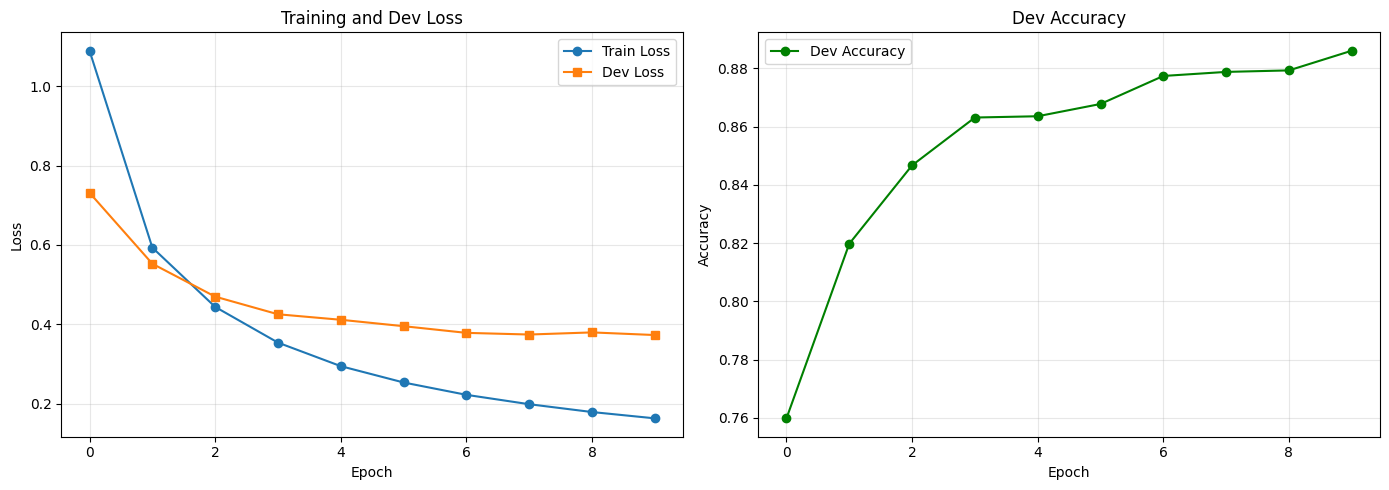

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot losses
axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(dev_losses, label='Dev Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Dev Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot dev accuracy
axes[1].plot(dev_accuracies, label='Dev Accuracy', marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Dev Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.4. Final Evaluation on Test Set

In [12]:
# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model from training.\n")

# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f"{'='*60}")
print("FINAL RESULTS")
print(f"{'='*60}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"{'='*60}")

Loaded best model from training.



Evaluating: 100%|██████████| 65/65 [00:00<00:00, 121.35it/s]

FINAL RESULTS
Test Loss: 0.3750
Test Accuracy: 0.8828 (88.28%)


### 5.5. Prediction Function for New Sentences

In [13]:
def predict_sentence(sentence, model, word_to_ix, ix_to_tag, device):
    """
    Predict POS tags for a new sentence.

    Args:
        sentence: str - Input sentence
        model: nn.Module - Trained model
        word_to_ix: Dict - Word vocabulary
        ix_to_tag: Dict - Tag vocabulary (inverse)
        device: torch.device

    Returns:
        List[Tuple[str, str]] - List of (word, predicted_tag) pairs
    """
    model.eval()

    # Tokenize (simple split by space)
    words = sentence.split()

    # Convert to indices
    unk_idx = word_to_ix['<UNK>']
    word_indices = [word_to_ix.get(word, unk_idx) for word in words]

    # Convert to tensor
    sentence_tensor = torch.LongTensor(word_indices).unsqueeze(0).to(device)  # [1, seq_len]

    # Predict
    with torch.no_grad():
        tag_scores = model(sentence_tensor)  # [1, seq_len, tagset_size]
        predictions = torch.argmax(tag_scores, dim=-1).squeeze(0)  # [seq_len]

    # Convert predictions to tags
    predicted_tags = [ix_to_tag[idx.item()] for idx in predictions]

    # Return word-tag pairs
    return list(zip(words, predicted_tags))

print("Prediction function defined successfully!")

Prediction function defined successfully!


### 5.6. Test Predictions on Example Sentences

In [14]:
# Test sentences
test_sentences_examples = [
    "I love NLP",
    "The cat sat on the mat",
    "Natural language processing is amazing",
    "She quickly ran to the store",
    "Deep learning models are powerful"
]

print("\n" + "="*60)
print("PREDICTIONS ON NEW SENTENCES")
print("="*60 + "\n")

for sentence in test_sentences_examples:
    predictions = predict_sentence(sentence, model, word_to_ix, ix_to_tag, device)

    print(f"Sentence: {sentence}")
    print(f"Predictions:")
    for word, tag in predictions:
        print(f"  {word:20s} -> {tag}")
    print()


PREDICTIONS ON NEW SENTENCES

Sentence: I love NLP
Predictions:
  I                    -> PRON
  love                 -> VERB
  NLP                  -> PROPN

Sentence: The cat sat on the mat
Predictions:
  The                  -> DET
  cat                  -> NOUN
  sat                  -> VERB
  on                   -> ADP
  the                  -> DET
  mat                  -> PROPN

Sentence: Natural language processing is amazing
Predictions:
  Natural              -> ADJ
  language             -> NOUN
  processing           -> VERB
  is                   -> AUX
  amazing              -> ADJ

Sentence: She quickly ran to the store
Predictions:
  She                  -> PRON
  quickly              -> ADV
  ran                  -> VERB
  to                   -> ADP
  the                  -> DET
  store                -> NOUN

Sentence: Deep learning models are powerful
Predictions:
  Deep                 -> PROPN
  learning             -> VERB
  models               -> NOUN
  are  

## Bonus: Detailed Analysis

In [15]:
# Per-tag accuracy analysis
def analyze_per_tag_accuracy(model, dataloader, device, ix_to_tag):
    """
    Calculate per-tag accuracy.
    """
    model.eval()
    tag_correct = {}
    tag_total = {}

    with torch.no_grad():
        for sentences, tags, lengths in dataloader:
            sentences = sentences.to(device)
            tags = tags.to(device)

            # Forward pass
            tag_scores = model(sentences)
            predictions = torch.argmax(tag_scores, dim=-1)

            # Calculate per-tag accuracy
            mask = (tags != 0)
            for i in range(tags.shape[0]):
                for j in range(tags.shape[1]):
                    if mask[i, j]:
                        true_tag = tags[i, j].item()
                        pred_tag = predictions[i, j].item()

                        tag_name = ix_to_tag[true_tag]
                        if tag_name not in tag_correct:
                            tag_correct[tag_name] = 0
                            tag_total[tag_name] = 0

                        tag_total[tag_name] += 1
                        if true_tag == pred_tag:
                            tag_correct[tag_name] += 1

    # Calculate accuracies
    tag_accuracies = {}
    for tag in tag_total:
        tag_accuracies[tag] = tag_correct[tag] / tag_total[tag] if tag_total[tag] > 0 else 0

    return tag_accuracies, tag_total

# Run analysis
tag_acc, tag_counts = analyze_per_tag_accuracy(model, test_loader, device, ix_to_tag)

print("\n" + "="*60)
print("PER-TAG ACCURACY ON TEST SET")
print("="*60 + "\n")

# Sort by frequency
sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)

print(f"{'Tag':<10} {'Count':<10} {'Accuracy':<10}")
print("-" * 30)
for tag, count in sorted_tags:
    if tag != '<PAD>':
        acc = tag_acc[tag]
        print(f"{tag:<10} {count:<10} {acc:.4f} ({acc*100:.2f}%)")


PER-TAG ACCURACY ON TEST SET

Tag        Count      Accuracy  
------------------------------
NOUN       4137       0.8376 (83.76%)
PUNCT      3096       0.9839 (98.39%)
VERB       2605       0.8706 (87.06%)
PRON       2161       0.9745 (97.45%)
ADP        2033       0.9370 (93.70%)
PROPN      1980       0.7919 (79.19%)
DET        1897       0.9541 (95.41%)
ADJ        1787       0.7941 (79.41%)
AUX        1543       0.9631 (96.31%)
ADV        1178       0.8413 (84.13%)
CCONJ      737        0.9905 (99.05%)
PART       649        0.9214 (92.14%)
NUM        542        0.6771 (67.71%)
SCONJ      384        0.5260 (52.60%)
X          136        0.1544 (15.44%)
INTJ       120        0.7000 (70.00%)
SYM        109        0.7890 (78.90%)


## Save Model

In [16]:
# Save model and vocabularies
torch.save({
    'model_state_dict': model.state_dict(),
    'word_to_ix': word_to_ix,
    'tag_to_ix': tag_to_ix,
    'ix_to_tag': ix_to_tag,
    'hyperparameters': {
        'embedding_dim': EMBEDDING_DIM,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS
    },
    'results': {
        'best_dev_acc': best_dev_acc,
        'test_acc': test_acc
    }
}, 'pos_tagging_model.pt')

print("Model saved to 'pos_tagging_model.pt'")

Model saved to 'pos_tagging_model.pt'
